#SELECTED TOPICS IN MUSIC AND ACOUSTICS ENGINEERING - FINAL PROJECT

Project 3 - Bird Activity Detection
 - Pier Matteo Marzola
 - Anna Chiara Melioli
 - Renmu Gong
 - Benedito Ferrao

Importing Relevant Packages


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
import pandas as pd
import random
from IPython.display import Audio, display
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
plt.style.use("seaborn-v0_8")

##Dataset Preparation


*   Download the Dataset



In [ ]:
# Not necessary if done locally



*   Load audio files and annotations



In [ ]:

# 1. Load  metadata CSV
meta_df = pd.read_csv('/Users/beneditoferrao/Desktop/STMAE project/warblrb10k_public_metadata_2018.csv')

# 2. Define columns and directory
ID_COL    = 'itemid'   # base filename (without “.wav”)
LABEL_COL = 'hasbird'  # 0/1 bird‐activity flag
WAV_DIR   = Path('/Users/beneditoferrao/Desktop/STMAE project/wav')  # full path to the wav folder

# 3. Build file path and filter to only files that actually exist
meta_df['file_path'] = meta_df[ID_COL].apply(lambda x: WAV_DIR / f"{x}.wav")
meta_df = meta_df[meta_df['file_path'].map(Path.exists)]

# 4. Extract usable files and labels
audio_files = meta_df['file_path'].astype(str).tolist()
labels      = meta_df[LABEL_COL].tolist()

# 5. Sanity check
print(f"Found {len(audio_files)} WAV files that exist in '{WAV_DIR}' and have labels")
for path, lab in zip(audio_files[:5], labels[:5]):
    print(f"  {path} → {lab}")

Found 8000 WAV files that exist in '/Users/beneditoferrao/Desktop/STMAE project/wav' and have labels
  /Users/beneditoferrao/Desktop/STMAE project/wav/759808e5-f824-401e-9058.wav → 1
  /Users/beneditoferrao/Desktop/STMAE project/wav/1d94fc4a-1c63-4da0-9cac.wav → 1
  /Users/beneditoferrao/Desktop/STMAE project/wav/bb0099ce-3073-4613-8557.wav → 1
  /Users/beneditoferrao/Desktop/STMAE project/wav/c4c67e81-9aa8-4af4-8eb7.wav → 1
  /Users/beneditoferrao/Desktop/STMAE project/wav/ab322d4b-da69-4b06-a065.wav → 0




*   Hearing some samples



In [ ]:
# Number of samples to hear
n_samples = 5

# Pair up paths & labels
pairs = list(zip(audio_files, labels))

# Randomly pick n_samples examples
selected = random.sample(pairs, n_samples)

# Display each with its label and audio player
for file_path, label in selected:
    print(f"File: {file_path}  →  has bird = {label}")
    display(Audio(filename=file_path, autoplay=False))

File: wav/b1fa3e52-c709-447a-b530.wav  →  has bird = 1


File: wav/627bc4e2-e5e7-4351-b9a3.wav  →  has bird = 1


File: wav/8bf5f9a6-ebc2-4bfd-9e3c.wav  →  has bird = 1


File: wav/adc97d82-3d7a-4a07-8154.wav  →  has bird = 1


File: wav/dd18f162-2ca8-46fc-8563.wav  →  has bird = 0


##Extracting features using STFT
* STFT for feature extraction

In [ ]:
# 1. Parameters for STFT
SR             = 22050        # target sample rate
DURATION       = 10.0         # seconds
TARGET_SAMPLES = int(SR * DURATION)
N_FFT          = 2048
HOP_LENGTH     = 1024

# 2. Prepare list for fixed‐shape STFT spectrograms
stft_specs_fixed = []

for fp in audio_files:
    # Load & resample the clip
    y, _ = librosa.load(fp, sr=SR)

    # Truncate or pad waveform to exactly TARGET_SAMPLES
    if len(y) > TARGET_SAMPLES:
        y = y[:TARGET_SAMPLES]
    else:
        y = np.pad(y, (0, TARGET_SAMPLES - len(y)), mode='constant')

    # Compute the STFT
    S_complex = librosa.stft(
        y,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    )
    # Take magnitude (you can also convert to dB with librosa.amplitude_to_db)
    S_mag = np.abs(S_complex)

    stft_specs_fixed.append(S_mag)

# 3. Verify they all have the same shape
shapes = set(spec.shape for spec in stft_specs_fixed)
print("Unique STFT shapes:", shapes)

# 4. Stack into a 3‐D array and build labels array
X_stft = np.stack(stft_specs_fixed, axis=0)  # shape: (n_samples, freq_bins, time_frames)
Ydata  = np.array(labels)                    # shape: (n_samples,)

print("X_stft.shape:", X_stft.shape)
print("Ydata.shape: ", Ydata.shape)


Unique STFT shapes: {(1025, 216)}
X_stft.shape: (8000, 1025, 216)
Ydata.shape:  (8000,)




*   Training/ Validation/ Test Split



In [ ]:
# 1. First split off the 10% test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_stft, Ydata,
    test_size=0.10,
    random_state=42,
    stratify=Ydata
)

# 2. Then split the remaining 90% into 70% train and 20% validation
val_frac = 0.20 / 0.90
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_frac,
    random_state=42,
    stratify=y_temp
)

# 3. Check that the shapes match the 70/20/10 proportions
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

X_train: (5600, 1025, 216), y_train: (5600,)
X_val:   (1600, 1025, 216),   y_val:   (1600,)
X_test:  (800, 1025, 216),  y_test:  (800,)




*   Reshape for using the CNN Model


In [ ]:
# Necessary reshape because by default, Keras assumes that the last dimension corresponds to the number of channels in our input
# and each frequency band will be processed as an independent frequency channel.
X_train_rs = np.moveaxis(X_train, 1, -1)
X_val_rs = np.moveaxis(X_val, 1, -1)
X_test_rs = np.moveaxis(X_test, 1, -1)

print('X_train_rs shape: {} \nX_val_rs shape: {} \nX_test_rs shape: {}'.format(X_train_rs.shape, X_val_rs.shape, X_test_rs.shape))

X_train_rs shape: (5600, 216, 1025) 
X_val_rs shape: (1600, 216, 1025) 
X_test_rs shape: (800, 216, 1025)




*   Compile the model



In [ ]:
# Input shape = (time_steps, features) == X_train_rs.shape[1:]
input_shape = X_train_rs.shape[1:]

model_fast = Sequential([
    # 1st conv block
    Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # 2nd conv block
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Global pooling to collapse the time axis
    GlobalAveragePooling1D(),
    Dropout(0.3),

    # Final binary output
    Dense(1, activation='sigmoid')
])

model_fast.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_fast.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 212, 32)           164032    
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 106, 32)           0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 106, 32)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 104, 64)           6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 52, 64)            0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 52, 64)            0



*   Train the model



In [ ]:
# 1. Callbacks (reuse your CSVLogger / EarlyStopping / ModelCheckpoint)
csv_logger       = CSVLogger('fast_STFT_noRNN_log.csv', append=False)
early_stop       = EarlyStopping('val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'fast_STFT_noRNN_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
callbacks_list = [csv_logger, early_stop, model_checkpoint]


# 2. Train directly on NumPy arrays
history = model_fast.fit(
    X_train_rs, y_train,
    batch_size=64,                     # larger batch for throughput
    epochs=100,                        # cap epochs; EarlyStopping will likely stop sooner
    validation_data=(X_val_rs, y_val),
    callbacks=callbacks_list,
    verbose=1,
    shuffle=True
)

Epoch 1/100
87/88 [============================>.] - ETA: 0s - loss: 0.5953 - accuracy: 0.7645
Epoch 1: val_accuracy improved from -inf to 0.81937, saving model to fast_STFT_noRNN_model.h5
88/88 [==============================] - 13s 147ms/step - loss: 0.5953 - accuracy: 0.7645 - val_loss: 0.4546 - val_accuracy: 0.8194
Epoch 2/100
 2/88 [..............................] - ETA: 5s - loss: 0.5204 - accuracy: 0.7969

/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/88 [============================>.] - ETA: 0s - loss: 0.4564 - accuracy: 0.8165
Epoch 2: val_accuracy improved from 0.81937 to 0.83000, saving model to fast_STFT_noRNN_model.h5
88/88 [==============================] - 6s 69ms/step - loss: 0.4562 - accuracy: 0.8164 - val_loss: 0.4459 - val_accuracy: 0.8300
Epoch 3/100
87/88 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8224
Epoch 3: val_accuracy improved from 0.83000 to 0.83562, saving model to fast_STFT_noRNN_model.h5
88/88 [==============================] - 6s 72ms/step - loss: 0.4337 - accuracy: 0.8229 - val_loss: 0.4202 - val_accuracy: 0.8356
Epoch 4/100
87/88 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8260
Epoch 4: val_accuracy improved from 0.83562 to 0.83625, saving model to fast_STFT_noRNN_model.h5
88/88 [==============================] - 6s 70ms/step - loss: 0.3996 - accuracy: 0.8261 - val_loss: 0.3885 - val_accuracy: 0.8363
Epoch 5/100
87/88 [===========================



*   Plot accuracy/ loss


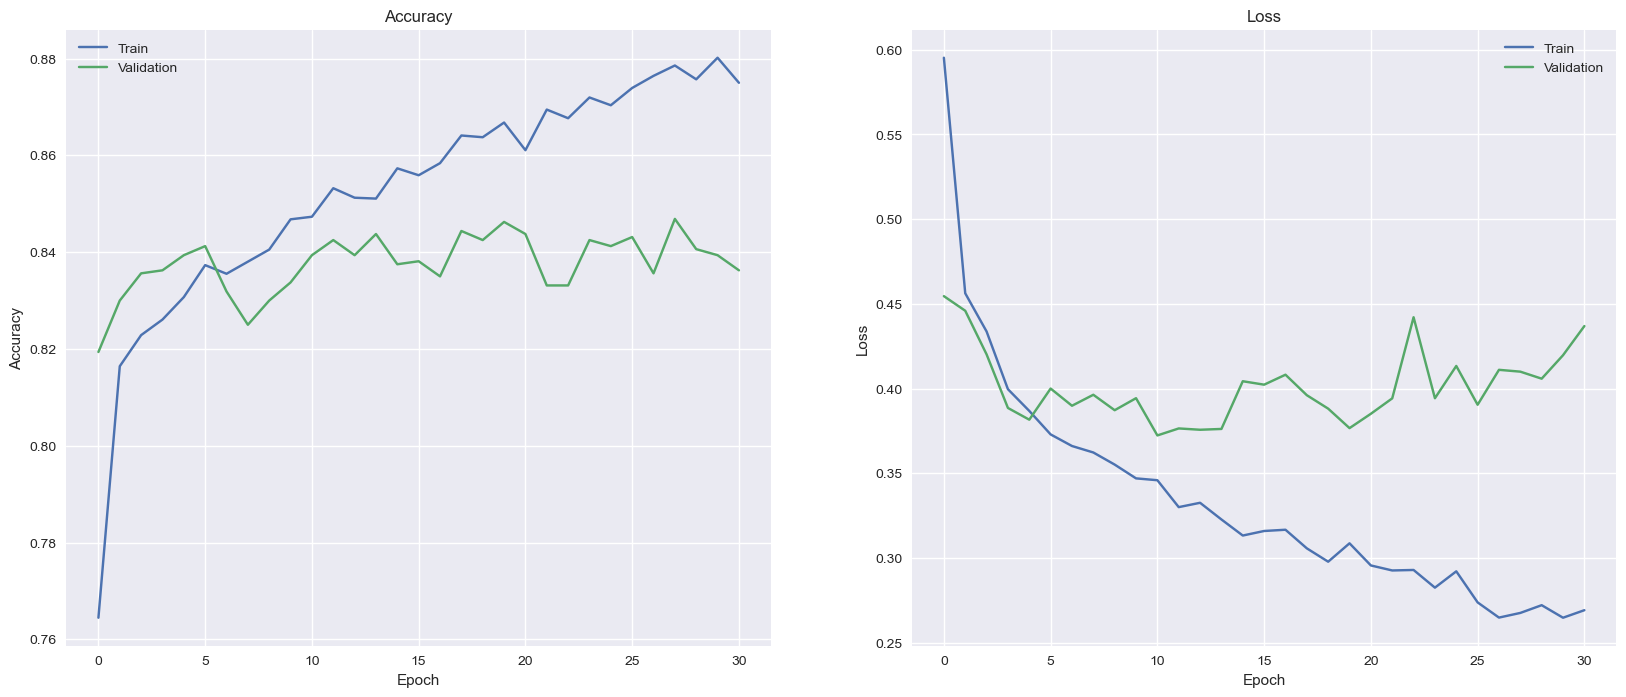

In [ ]:
#Training history
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])


plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()



*   Evaluate on Test Set



In [ ]:
#Optimal weights
model_fast.load_weights('fast_STFT_noRNN_model.h5')
val_loss, val_acc = model_fast.evaluate(X_val_rs, y_val)
print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')
test_loss, test_acc = model_fast.evaluate(X_test_rs, y_test)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


50/50 [==============================] - 1s 15ms/step - loss: 0.4100 - accuracy: 0.8469
Validation accuracy: 0.8469, Validation loss: 0.4100
25/25 [==============================] - 1s 15ms/step - loss: 0.4024 - accuracy: 0.8338
Test accuracy: 0.8338, Test loss: 0.4024




*   Confusion Matrices




50/50 [==============================] - 1s 14ms/step


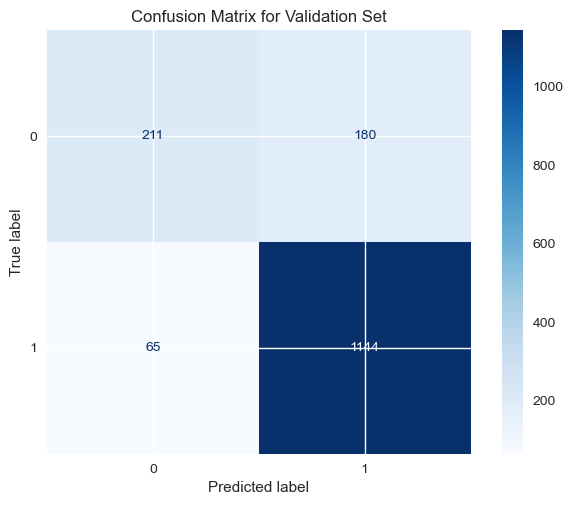

25/25 [==============================] - 0s 15ms/step


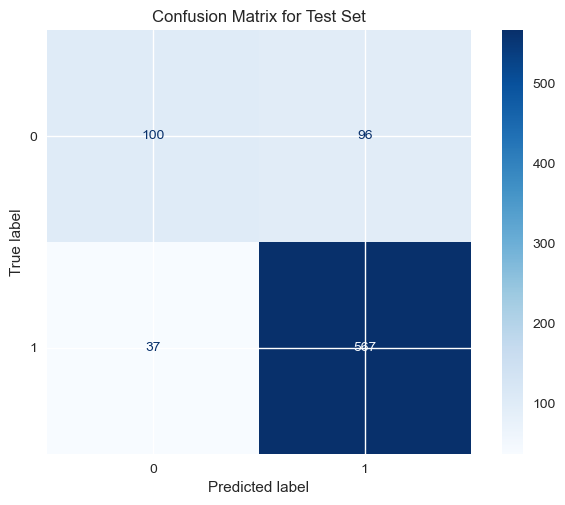

In [ ]:
# --- Validation set ---
# Predict probabilities
y_prob_val = model_fast.predict(X_val_rs)

# Threshold at 0.5 to get binary predictions
y_pred_val = (y_prob_val.flatten() > 0.5).astype(int)

# Compute & display
cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=[0, 1]
)
disp_val.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()


# --- Test set ---
y_prob_test = model_fast.predict(X_test_rs)
y_pred_test = (y_prob_test.flatten() > 0.5).astype(int)

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=[0, 1]
)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()



*   Classification Report



In [ ]:
print(classification_report(y_val, y_pred_val))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.54      0.63       391
           1       0.86      0.95      0.90      1209

    accuracy                           0.85      1600
   macro avg       0.81      0.74      0.77      1600
weighted avg       0.84      0.85      0.84      1600

              precision    recall  f1-score   support

           0       0.73      0.51      0.60       196
           1       0.86      0.94      0.90       604

    accuracy                           0.83       800
   macro avg       0.79      0.72      0.75       800
weighted avg       0.82      0.83      0.82       800



## Extracting features using log Mel spectrograms




*   Extract Features using the Mel Spectogram




In [ ]:
import librosa
import numpy as np
from tqdm.notebook import tqdm

# === PARAMETERS ===
SR             = 22050
DURATION       = 10.0
TARGET_SAMPLES = int(SR * DURATION)

N_MELS         = 64
N_FFT          = 2048
HOP_LENGTH     = 1024
FMAX           = SR // 2
EXPECTED_FRAMES = int(np.ceil(TARGET_SAMPLES / HOP_LENGTH))

# === Placeholder for Mel-spectrograms ===
melspecs_fixed = []

# === Loop over files ===
for fp in tqdm(audio_files, desc="Extracting Mel Spectrograms"):
    try:
        # 1. Load and resample
        y, _ = librosa.load(fp, sr=SR)

        # 2. Fix length
        if len(y) < TARGET_SAMPLES:
            y = np.pad(y, (0, TARGET_SAMPLES - len(y)))
        else:
            y = y[:TARGET_SAMPLES]

        # 3. Compute Mel-spectrogram
        S = librosa.feature.melspectrogram(
            y=y,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            fmax=FMAX
        )

        # 4. Validate shape and store
        if S.shape[1] == EXPECTED_FRAMES:
            melspecs_fixed.append(S.astype(np.float32))  # save memory
        else:
            print(f"Skipped {fp}: shape {S.shape} (expected {EXPECTED_FRAMES})")

    except Exception as e:
        print(f"Error processing {fp}: {e}")

# === Convert to NumPy array ===
melspecs_fixed = np.stack(melspecs_fixed)
print("Done. Final shape:", melspecs_fixed.shape)

# === Save to disk for reuse (optional) ===
np.save("mel_specs.npy", melspecs_fixed)


Extracting Mel Spectrograms:   0%|          | 0/8000 [00:00<?, ?it/s]

✅ Done. Final shape: (8000, 64, 216)


In [ ]:
# Verify a single unique shape
shapes = set(spec.shape for spec in melspecs_fixed)
print("Unique spectrogram shapes:", shapes)

# Stack into a 3‐D array
Xdata = np.stack(melspecs_fixed, axis=0)
Ydata = np.array(labels)

print("Xdata.shape:", Xdata.shape)
print("Ydata.shape:", Ydata.shape)

Unique spectrogram shapes: {(64, 216)}
Xdata.shape: (8000, 64, 216)
Ydata.shape: (8000,)




*   Training/ Validation/ Test Split



In [ ]:
# First split off the 10% test set
X_temp, X_test, y_temp, y_test = train_test_split(
    Xdata, Ydata,
    test_size=0.10,
    random_state=42,
    stratify=Ydata
)

# Then split the remaining 90% into 70% train vs. 20% validation
#    (i.e. validation is 0.20/0.90 ≈ 0.2222 of X_temp)
val_frac = 0.20 / 0.90
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_frac,
    random_state=42,
    stratify=y_temp
)

# Check shapes
print(f"X_train: {X_train.shape},  y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},    y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},   y_test:  {y_test.shape}")

X_train: (5600, 64, 216),  y_train: (5600,)
X_val:   (1600, 64, 216),    y_val:   (1600,)
X_test:  (800, 64, 216),   y_test:  (800,)




*   Use the Hybrid CNN Model



In [ ]:
# Necessary reshape because by default, Keras assumes that the last dimension corresponds to the number of channels in our input
# and each frequency band will be processed as an independent frequency channel.
X_train_rs = np.moveaxis(X_train, 1, -1)
X_val_rs = np.moveaxis(X_val, 1, -1)
X_test_rs = np.moveaxis(X_test, 1, -1)

print('X_train_rs shape: {} \nX_val_rs shape: {} \nX_test_rs shape: {}'.format(X_train_rs.shape, X_val_rs.shape, X_test_rs.shape))

X_train_rs shape: (5600, 216, 64) 
X_val_rs shape: (1600, 216, 64) 
X_test_rs shape: (800, 216, 64)


In [ ]:
X_train_rss = np.expand_dims(X_train_rs, axis=3)
X_val_rss = np.expand_dims(X_val_rs, axis=3)
X_test_rss = np.expand_dims(X_test_rs, axis=3)

print(f'Original size:\n X_train_rs.shape=', X_train_rs.shape, '\n X_val_rs.shape=', X_val_rs.shape, '\n X_test_rs.shape=', X_test_rs.shape)
print(f'\nNew size \n X_train_rss.shape=X_train_rss.shape', X_train_rss.shape, '\n X_val_rss.shape=', X_val_rss.shape, '\n X_test_rss.shape=', X_test_rss.shape)

Original size:
 X_train_rs.shape= (5600, 216, 64) 
 X_val_rs.shape= (1600, 216, 64) 
 X_test_rs.shape= (800, 216, 64)

New size 
 X_train_rss.shape=X_train_rss.shape (5600, 216, 64, 1) 
 X_val_rss.shape= (1600, 216, 64, 1) 
 X_test_rss.shape= (800, 216, 64, 1)




*   Create and compile the model



In [ ]:
input_shape = X_train_rss.shape[1:]   # (time_steps, features, channels)
print('Using input_shape =', input_shape)

model_hyb = Sequential([
    TimeDistributed(Conv1D(16, 9, activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Conv1D(16, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Conv1D(32, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Flatten()),

    LSTM(16, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dropout(0.35),

    Dense(1, activation='sigmoid')
])

model_hyb.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_hyb.summary()

Using input_shape = (216, 64, 1)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 216, 56, 16)    │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 216, 28, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 216, 28, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 216, 26, 16)    │           784 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 216, 13, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 216, 13, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 216, 11, 32)    │         1,568 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 216, 6, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 216, 6, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 216, 192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 216, 16)        │        13,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,905 (62.13 KB)

 Trainable params: 15,905 (62.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set up callbacks
csv_logger = CSVLogger('Hybrid_CNN_RNN_training_log.csv', append=False)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'Hybrid_CNN_RNN_Classifier.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
callbacks_list = [csv_logger, early_stop, model_checkpoint]

# Train
history = model_hyb.fit(
    X_train_rss, y_train,
    batch_size=32,
    epochs=100,                 # fewer epochs for testing
    validation_data=(X_val_rss, y_val),
    callbacks=callbacks_list,
    verbose=1                   # show per-batch progress
)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7429 - loss: 0.5586
Epoch 1: val_accuracy improved from -inf to 0.77312, saving model to Hybrid_CNN_RNN_Classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.7430 - loss: 0.5584 - val_accuracy: 0.7731 - val_loss: 0.4726
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7737 - loss: 0.4812
Epoch 2: val_accuracy improved from 0.77312 to 0.81187, saving model to Hybrid_CNN_RNN_Classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.7738 - loss: 0.4812 - val_accuracy: 0.8119 - val_loss: 0.4327
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7861 - loss: 0.4693
Epoch 3: val_accuracy improved from 0.81187 to 0.81937, saving model to Hybrid_CNN_RNN_Classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.7862 - loss: 0.4692 - val_accuracy: 0.8194 - val_loss: 0.4100
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8150 - loss: 0.4195
Epoch 4: val_accuracy improved from 0.81937 to 0.82625, saving model to Hybrid_CNN_RNN_Classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1608s 9s/step - accuracy: 0.8150 - loss: 0.4195 - val_accuracy: 0.8263 - val_loss: 0.3960
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8195 - loss: 0.4061 
Epoch 5: val_accuracy did not improve from 0.82625
175/175 ━━━━━━━━━━━━━━━━━━━━ 4054s 23s/step - accuracy: 0.8195 - loss: 0.4061 - val_accuracy: 0.8238 - val_loss: 0.3924
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8049 - loss: 0.4248 
Epoch 6: val_accuracy improved from 0.82625 to 0.83562, saving model to Hybrid_CNN_RNN_Classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 5217s 30s/step - accuracy: 0.8049 - loss: 0.4246 - val_accuracy: 0.8356 - val_loss: 0.3881
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8131 - loss: 0.4020 
Epoch 7: val_accuracy did not improve from 0.83562
175/175 ━━━━━━━━━━━━━━━━━━━━ 3909s 22s/step - accuracy: 0.8132 - loss: 0.4020 - val_accuracy: 0.8319 - val_loss: 0.3705
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8228 - loss: 0.3830 
Epoch 8: val_accuracy did not improve from 0.83562
175/175 ━━━━━━━━━━━━━━━━━━━━ 3520s 20s/step - accuracy: 0.8228 - loss: 0.3830 - val_accuracy: 0.8313 - val_loss: 0.3744
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8210 - loss: 0.3848 
Epoch 9: val_accuracy did not improve from 0.83562
175/175 ━━━━━━━━━━━━━━━━━━━━ 3464s 20s/step - accuracy: 0.8210 - loss: 0.3848 - val_accuracy: 0.8338 - val_loss: 0.3672
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8380 - loss: 0.3674 
Epoch 10: val_

175/175 ━━━━━━━━━━━━━━━━━━━━ 2256s 13s/step - accuracy: 0.8377 - loss: 0.3654 - val_accuracy: 0.8413 - val_loss: 0.3649
Epoch 12/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8322 - loss: 0.3660
Epoch 12: val_accuracy did not improve from 0.84125
175/175 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.8322 - loss: 0.3660 - val_accuracy: 0.8413 - val_loss: 0.3626
Epoch 13/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8331 - loss: 0.3662
Epoch 13: val_accuracy improved from 0.84125 to 0.84188, saving model to Hybrid_CNN_RNN_Classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.8331 - loss: 0.3662 - val_accuracy: 0.8419 - val_loss: 0.3616
Epoch 14/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8302 - loss: 0.3659
Epoch 14: val_accuracy did not improve from 0.84188
175/175 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.8302 - loss: 0.3658 - val_accuracy: 0.8350 - val_loss: 0.3616
Epoch 15/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8349 - loss: 0.3679
Epoch 15: val_accuracy improved from 0.84188 to 0.84375, saving model to Hybrid_CNN_RNN_Classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.8350 - loss: 0.3679 - val_accuracy: 0.8438 - val_loss: 0.3552
Epoch 16/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8450 - loss: 0.3508
Epoch 16: val_accuracy did not improve from 0.84375
175/175 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.8449 - loss: 0.3508 - val_accuracy: 0.8344 - val_loss: 0.3710
Epoch 17/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8456 - loss: 0.3626
Epoch 17: val_accuracy did not improve from 0.84375
175/175 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.8456 - loss: 0.3626 - val_accuracy: 0.8381 - val_loss: 0.3531
Epoch 18/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8243 - loss: 0.3675
Epoch 18: val_accuracy did not improve from 0.84375
175/175 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.8243 - loss: 0.3674 - val_accuracy: 0.8425 - val_loss: 0.3525
Epoch 19/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8479 - loss: 0.3450
Epoch 19: val_accuracy d

175/175 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - accuracy: 0.8494 - loss: 0.3379 - val_accuracy: 0.8444 - val_loss: 0.3492
Epoch 21/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8452 - loss: 0.3373
Epoch 21: val_accuracy did not improve from 0.84438
175/175 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.8452 - loss: 0.3373 - val_accuracy: 0.8413 - val_loss: 0.3466
Epoch 22/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8427 - loss: 0.3465
Epoch 22: val_accuracy did not improve from 0.84438
175/175 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.8427 - loss: 0.3465 - val_accuracy: 0.8425 - val_loss: 0.3451
Epoch 23/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8429 - loss: 0.3356
Epoch 23: val_accuracy did not improve from 0.84438
175/175 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.8429 - loss: 0.3356 - val_accuracy: 0.8381 - val_loss: 0.3491
Epoch 24/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8430 - loss: 0.3448
Epoch 24: val_accuracy d

175/175 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.8481 - loss: 0.3406 - val_accuracy: 0.8519 - val_loss: 0.3420
Epoch 28/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8482 - loss: 0.3259
Epoch 28: val_accuracy did not improve from 0.85188
175/175 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - accuracy: 0.8482 - loss: 0.3260 - val_accuracy: 0.8431 - val_loss: 0.3391
Epoch 29/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8355 - loss: 0.3476
Epoch 29: val_accuracy did not improve from 0.85188
175/175 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.8356 - loss: 0.3476 - val_accuracy: 0.8425 - val_loss: 0.3425
Epoch 30/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8433 - loss: 0.3411
Epoch 30: val_accuracy did not improve from 0.85188
175/175 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.8433 - loss: 0.3410 - val_accuracy: 0.8400 - val_loss: 0.3478
Epoch 31/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8562 - loss: 0.3150
Epoch 31: val_accuracy d

175/175 ━━━━━━━━━━━━━━━━━━━━ 623s 4s/step - accuracy: 0.8615 - loss: 0.3204 - val_accuracy: 0.8587 - val_loss: 0.3308
Epoch 53/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8531 - loss: 0.3211
Epoch 53: val_accuracy did not improve from 0.85875
175/175 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.8532 - loss: 0.3211 - val_accuracy: 0.8475 - val_loss: 0.3315
Epoch 54/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8494 - loss: 0.3233
Epoch 54: val_accuracy did not improve from 0.85875
175/175 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.8495 - loss: 0.3233 - val_accuracy: 0.8506 - val_loss: 0.3380
Epoch 55/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8602 - loss: 0.3013
Epoch 55: val_accuracy did not improve from 0.85875
175/175 ━━━━━━━━━━━━━━━━━━━━ 1144s 7s/step - accuracy: 0.8602 - loss: 0.3014 - val_accuracy: 0.8381 - val_loss: 0.3439
Epoch 56/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8559 - loss: 0.3207
Epoch 56: val_accuracy 



*   Plot accuracy/ loss


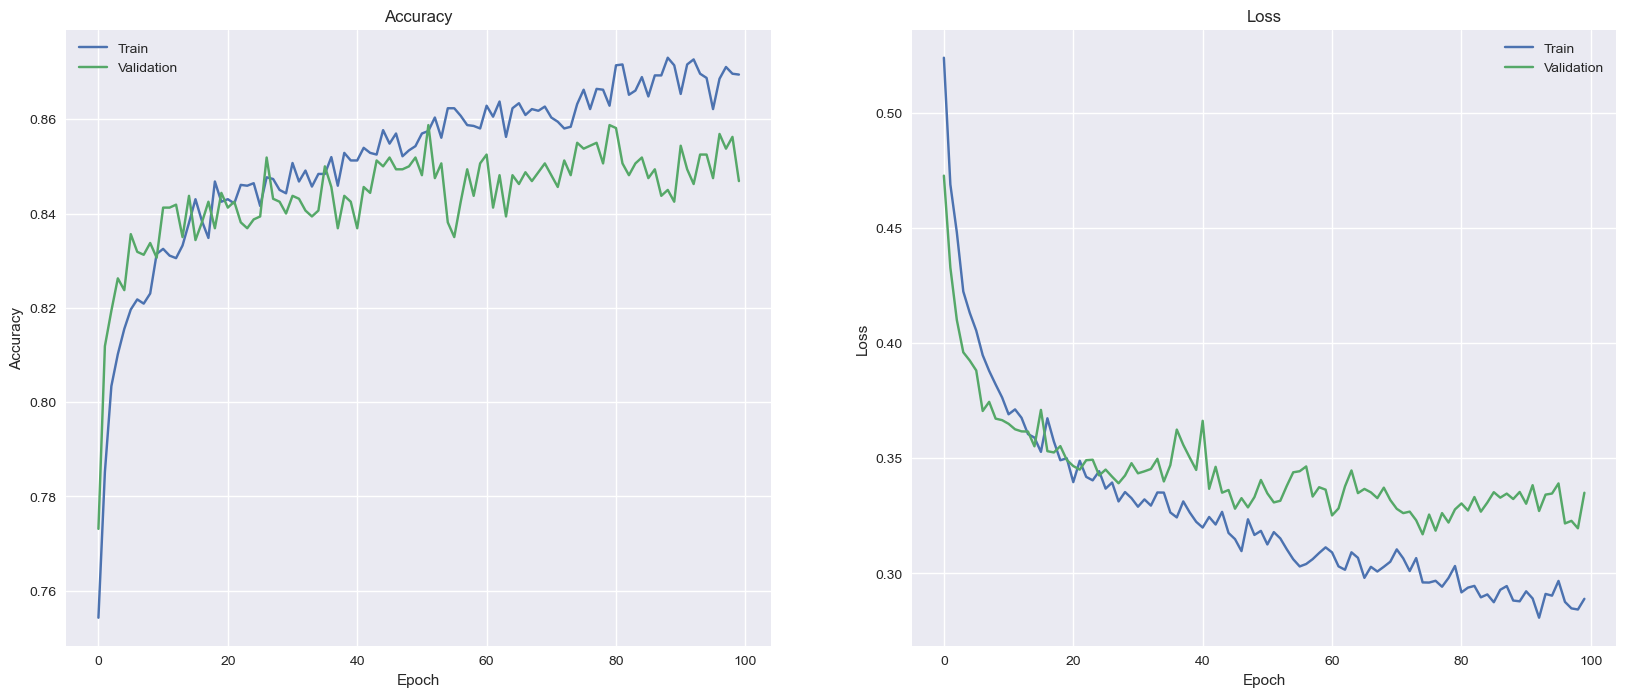

In [ ]:
#Training history
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])


plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()



*   Evaluation on Test Set



In [ ]:
#Optimal weights
model_hyb.load_weights('Hybrid_CNN_RNN_Classifier.h5')
val_loss, val_acc = model_hyb.evaluate(X_val_rss, y_val)
print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')
test_loss, test_acc = model_hyb.evaluate(X_test_rss, y_test)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8654 - loss: 0.3130
Validation accuracy: 0.8587, Validation loss: 0.3308
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8313 - loss: 0.3708
Test accuracy: 0.8388, Test loss: 0.3440




*   Confusion Matrices




50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


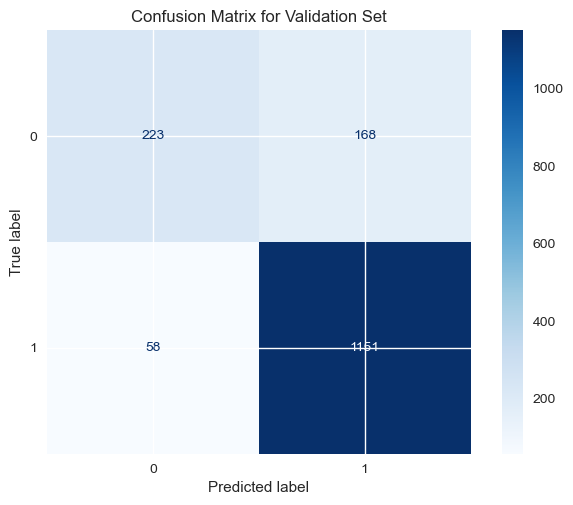

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


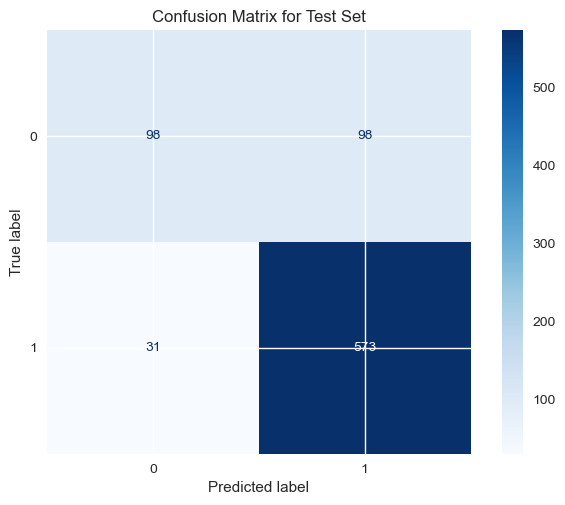

In [ ]:
# --- Validation set ---
y_prob_val = model_hyb.predict(X_val_rss)

y_pred_val = (y_prob_val.flatten() > 0.5).astype(int)

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=[0, 1]
)
disp_val.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()


# --- Test set ---
y_prob_test = model_hyb.predict(X_test_rss)
y_pred_test = (y_prob_test.flatten() > 0.5).astype(int)

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=[0, 1]
)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()



*   Classification Report



In [ ]:
print(classification_report(y_val, y_pred_val))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.57      0.66       391
           1       0.87      0.95      0.91      1209

    accuracy                           0.86      1600
   macro avg       0.83      0.76      0.79      1600
weighted avg       0.85      0.86      0.85      1600

              precision    recall  f1-score   support

           0       0.76      0.50      0.60       196
           1       0.85      0.95      0.90       604

    accuracy                           0.84       800
   macro avg       0.81      0.72      0.75       800
weighted avg       0.83      0.84      0.83       800



## Data augmentation using Mel-spectrogram

EXPERIMENTS: log-mel spectrogram, normalization, random augmentation (time shift, noise injection, time stretching, pitch shifting).

Found 8000 WAV files with labels
  wav/759808e5-f824-401e-9058.wav → 1
  wav/1d94fc4a-1c63-4da0-9cac.wav → 1
  wav/bb0099ce-3073-4613-8557.wav → 1
  wav/c4c67e81-9aa8-4af4-8eb7.wav → 1
  wav/ab322d4b-da69-4b06-a065.wav → 0

Label distribution:
hasbird
1    6045
0    1955
Name: count, dtype: int64


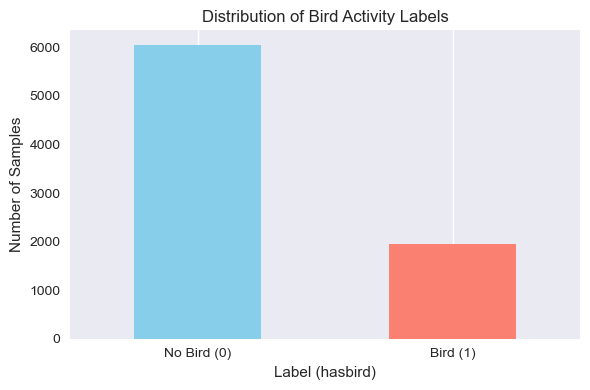

In [ ]:
# 1. Load your metadata CSV
meta_df = pd.read_csv('warblrb10k_public_metadata_2018.csv')

# 2. Define the relevant columns
ID_COL    = 'itemid'   # base filename (without “.wav”)
LABEL_COL = 'hasbird'  # 0/1 bird‐activity flag
WAV_DIR   = Path('wav')

# 3. Build a full-path column and filter to existing files
meta_df['file_path'] = meta_df[ID_COL].apply(lambda x: WAV_DIR / f"{x}.wav")
meta_df = meta_df[meta_df['file_path'].map(Path.exists)]

# 4. Extract your two parallel lists
audio_files = meta_df['file_path'].astype(str).tolist()
labels      = meta_df[LABEL_COL].tolist()

# 5. Sanity check
print(f"Found {len(audio_files)} WAV files with labels")
for path, lab in zip(audio_files[:5], labels[:5]):
    print(f"  {path} → {lab}")

# 6. Analyze labels distribution
label_counts = meta_df[LABEL_COL].value_counts()
print("\nLabel distribution:")
print(label_counts)

# Plot the distribution
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Bird Activity Labels')
plt.xlabel('Label (hasbird)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['No Bird (0)', 'Bird (1)'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

*The graph is wrong: the labels are inverted, we have much more audio with birds than without.*

In [ ]:
from tqdm import tqdm
from collections import Counter

# --- Parameters ---
SR = 22050
DURATION = 10.0
TARGET_SAMPLES = int(SR * DURATION)
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 1024
FMAX = SR // 2

np.complex = complex

# --- data augmentation ---
def augment_audio(y, sr):
    if random.random() < 0.5:
        shift = int(sr * random.uniform(-1.0, 1.0))
        y = np.roll(y, shift)

    if random.random() < 0.5:
        noise = np.random.normal(0, 0.005, len(y))
        y += noise

    if random.random() < 0.3:
        steps = random.randint(-2, 2)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=steps)

    if random.random() < 0.3:
        rate = random.uniform(0.8, 1.2)
        y = librosa.resample(y, orig_sr=sr, target_sr=int(sr * rate))

    return y

# --- Preprocessing: load, normalize, padding, mel ---
def preprocess_file(fp, sr=SR, augment=False):
    y, _ = librosa.load(fp, sr=sr)

    if augment:
        y = augment_audio(y, sr=sr)

    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    if len(y) > TARGET_SAMPLES:
        y = y[:TARGET_SAMPLES]
    else:
        y = np.pad(y, (0, TARGET_SAMPLES - len(y)))

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                       hop_length=HOP_LENGTH, n_mels=N_MELS, fmax=FMAX)
    return librosa.power_to_db(S, ref=np.max)

# --- load metadata e file ---
meta_df = pd.read_csv("warblrb10k_public_metadata_2018.csv")
meta_df['file_path'] = meta_df['itemid'].apply(lambda x: Path("wav") / f"{x}.wav")
meta_df = meta_df[meta_df['file_path'].map(Path.exists)]

audio_files = meta_df['file_path'].astype(str).tolist()
labels = meta_df['hasbird'].tolist()

# --- Split: train / val / test ---
files_temp, files_test, y_temp, y_test = train_test_split(
    audio_files, labels, test_size=0.1, stratify=labels, random_state=42
)

val_frac = 0.2 / 0.9
files_train, files_val, y_train, y_val = train_test_split(
    files_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)

# --- Preprocessing ---
def process_dataset(file_list, augment=False):
    return [preprocess_file(fp, augment=augment) for fp in tqdm(file_list, desc=f"Processing {'Train (aug)' if augment else 'Set'}")]

print("➡️  Preprocessing TRAIN set (con augmentation)...")
X_train = np.stack(process_dataset(files_train, augment=True))
y_train = np.array(y_train)

print("➡️  Preprocessing VALIDATION set...")
X_val = np.stack(process_dataset(files_val, augment=False))
y_val = np.array(y_val)

print("➡️  Preprocessing TEST set...")
X_test = np.stack(process_dataset(files_test, augment=False))
y_test = np.array(y_test)

# --- Info ---
print(f"\n✅ Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

def label_distribution(y, name):
    c = Counter(y)
    print(f"{name} label distribution: {dict(c)}")

label_distribution(y_train, "Train")
label_distribution(y_val, "Validation")
label_distribution(y_test, "Test")

➡️  Preprocessing TRAIN set (con augmentation)...


Processing Train (aug): 100%|███████████████| 5600/5600 [02:53<00:00, 32.36it/s]


➡️  Preprocessing VALIDATION set...


Processing Set: 100%|███████████████████████| 1600/1600 [00:17<00:00, 90.56it/s]


➡️  Preprocessing TEST set...


Processing Set: 100%|█████████████████████████| 800/800 [00:08<00:00, 96.89it/s]


✅ Shapes:
X_train: (5600, 64, 216), y_train: (5600,)
X_val:   (1600, 64, 216), y_val:   (1600,)
X_test:  (800, 64, 216), y_test:  (800,)
Train label distribution: {1: 4232, 0: 1368}
Validation label distribution: {1: 1209, 0: 391}
Test label distribution: {0: 196, 1: 604}


In [ ]:
X_train_rs = np.moveaxis(X_train, 1, -1)
X_val_rs = np.moveaxis(X_val, 1, -1)
X_test_rs = np.moveaxis(X_test, 1, -1)

X_train_rss = np.expand_dims(X_train_rs, axis=3)
X_val_rss = np.expand_dims(X_val_rs, axis=3)
X_test_rss = np.expand_dims(X_test_rs, axis=3)

print(f'Original size:\n X_train_rs.shape=', X_train_rs.shape, '\n X_val_rs.shape=', X_val_rs.shape, '\n X_test_rs.shape=', X_test_rs.shape)
print(f'\nNew size \n X_train_rss.shape=X_train_rss.shape', X_train_rss.shape, '\n X_val_rss.shape=', X_val_rss.shape, '\n X_test_rss.shape=', X_test_rss.shape)

Original size:
 X_train_rs.shape= (5600, 216, 64) 
 X_val_rs.shape= (1600, 216, 64) 
 X_test_rs.shape= (800, 216, 64)

New size 
 X_train_rss.shape=X_train_rss.shape (5600, 216, 64, 1) 
 X_val_rss.shape= (1600, 216, 64, 1) 
 X_test_rss.shape= (800, 216, 64, 1)


In [ ]:
input_shape = X_train_rss.shape[1:]  # e.g., (216, 1, 64)
print('Using input_shape =', input_shape)

model_hyb = Sequential([
    TimeDistributed(Conv1D(16, 9, activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Conv1D(16, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Conv1D(32, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Flatten()),

    LSTM(32, return_sequences=True),
    GlobalAveragePooling1D(),
    Dropout(0.35),

    Dense(1, activation='sigmoid')
])

model_hyb.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_hyb.summary()

Using input_shape = (216, 64, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 216, 56, 16)       160       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 216, 28, 16)       0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 216, 28, 16)       0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 216, 26, 16)       784       
 stributed)                                                      
                                                                 
 time_distributed_4 (Ti

In [ ]:
# 1. Set up callbacks
csv_logger = CSVLogger('Hybrid_CNN_RNN_augmented_training_log.csv', append=False)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'Hybrid_CNN_RNN_augmented_Classifier.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
callbacks_list = [csv_logger, early_stop, model_checkpoint]

# 3. Train
history = model_hyb.fit(
    X_train_rss, y_train,
    batch_size=32,
    epochs=100,                 # fewer epochs for testing
    validation_data=(X_val_rss, y_val),
    callbacks=callbacks_list,
    verbose=1                   # show per-batch progress
)

Epoch 1/100
175/175 [==============================] - ETA: 0s - loss: 0.5599 - accuracy: 0.7550
Epoch 1: val_accuracy improved from -inf to 0.75563, saving model to Hybrid_CNN_RNN_augmented_Classifier.h5
175/175 [==============================] - 16s 89ms/step - loss: 0.5599 - accuracy: 0.7550 - val_loss: 0.6326 - val_accuracy: 0.7556
Epoch 2/100
  2/175 [..............................] - ETA: 14s - loss: 0.6055 - accuracy: 0.7344

/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


175/175 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.7646
Epoch 2: val_accuracy improved from 0.75563 to 0.77250, saving model to Hybrid_CNN_RNN_augmented_Classifier.h5
175/175 [==============================] - 15s 87ms/step - loss: 0.5047 - accuracy: 0.7646 - val_loss: 0.4737 - val_accuracy: 0.7725
Epoch 3/100
175/175 [==============================] - ETA: 0s - loss: 0.4373 - accuracy: 0.7961
Epoch 3: val_accuracy did not improve from 0.77250
175/175 [==============================] - 15s 85ms/step - loss: 0.4373 - accuracy: 0.7961 - val_loss: 0.4501 - val_accuracy: 0.7713
Epoch 4/100
175/175 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8005
Epoch 4: val_accuracy improved from 0.77250 to 0.81937, saving model to Hybrid_CNN_RNN_augmented_Classifier.h5
175/175 [==============================] - 15s 86ms/step - loss: 0.4037 - accuracy: 0.8005 - val_loss: 0.3856 - val_accuracy: 0.8194
Epoch 5/100
175/175 [============================

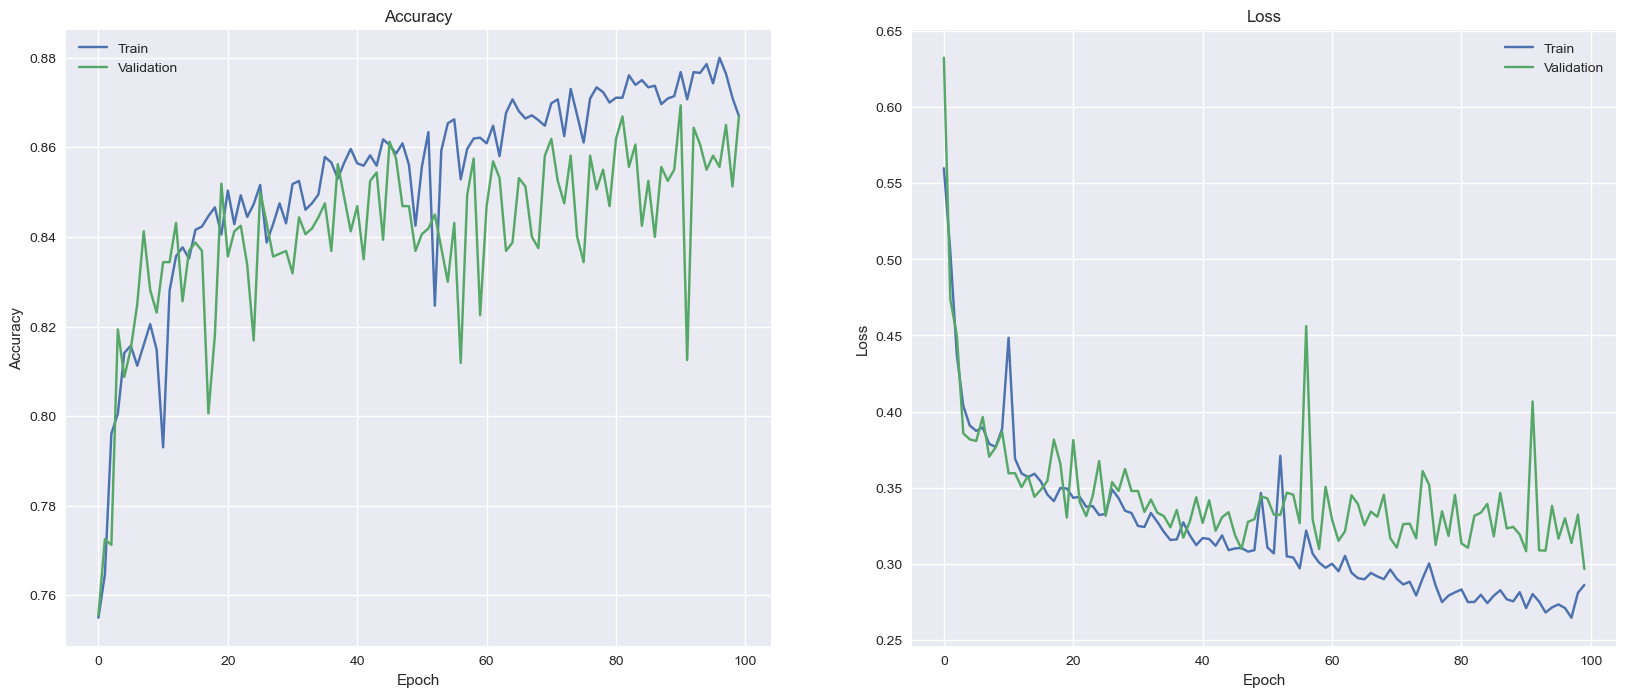

In [ ]:
#Training history
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])


plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

50/50 [==============================] - 1s 20ms/step - loss: 0.3081 - accuracy: 0.8694
Validation accuracy: 0.8694, Validation loss: 0.3081
25/25 [==============================] - 1s 21ms/step - loss: 0.3403 - accuracy: 0.8388
Test accuracy: 0.8388, Test loss: 0.3403
50/50 [==============================] - 1s 19ms/step


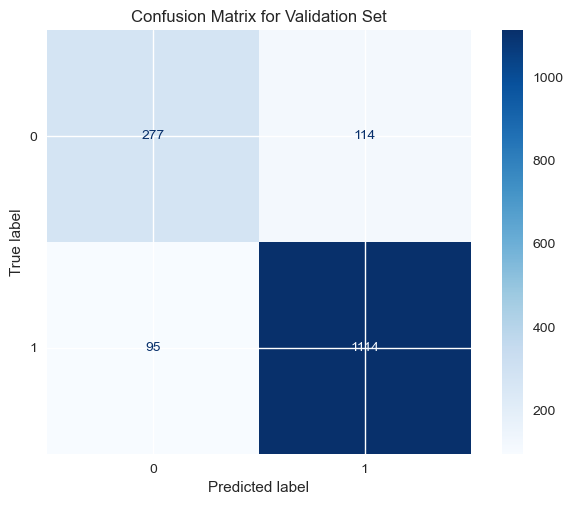

25/25 [==============================] - 1s 20ms/step


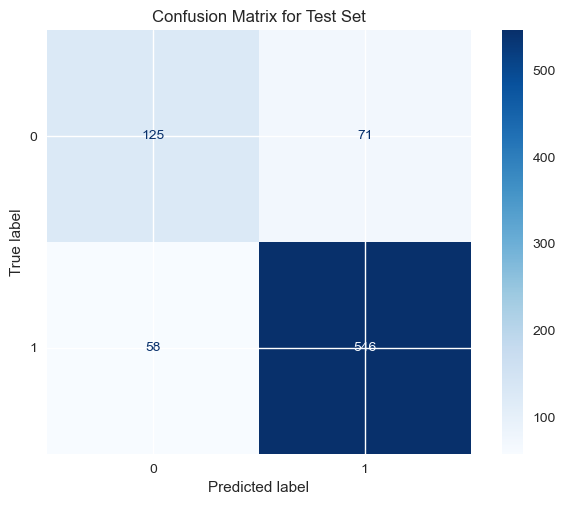

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       391
           1       0.91      0.92      0.91      1209

    accuracy                           0.87      1600
   macro avg       0.83      0.81      0.82      1600
weighted avg       0.87      0.87      0.87      1600

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       196
           1       0.88      0.90      0.89       604

    accuracy                           0.84       800
   macro avg       0.78      0.77      0.78       800
weighted avg       0.84      0.84      0.84       800



In [ ]:
#Optimal weights
model_hyb.load_weights('Hybrid_CNN_RNN_augmented_Classifier.h5')
val_loss, val_acc = model_hyb.evaluate(X_val_rss, y_val)
print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')
test_loss, test_acc = model_hyb.evaluate(X_test_rss, y_test)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

#------- confusion matrices

# Validation set ---
# 1) Predict probabilities
y_prob_val = model_hyb.predict(X_val_rss)

# 2) Threshold at 0.5 to get binary predictions
y_pred_val = (y_prob_val.flatten() > 0.5).astype(int)

# 3) Compute & display
cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=[0, 1]
)
disp_val.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()


# Test set ---
y_prob_test = model_hyb.predict(X_test_rss)
y_pred_test = (y_prob_test.flatten() > 0.5).astype(int)

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=[0, 1]
)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()

#---- classification reports
#Classification reports
print(classification_report(y_val, y_pred_val))
print(classification_report(y_test, y_pred_test))

## Adding noise to the testing test

* Adding noise with python functions

In [ ]:
import soundfile as sf

# === PARAMETERS ===
SR = 22050                              # Target sample rate
NOISE_DIR = Path("/Users/beneditoferrao/Desktop/STMAE Project/noise_files")  # Update this path!
NOISE_LEVEL = 0.4                       # 0.0 (no noise) to 1.0 (all noise)
OUTPUT_DIR = Path("noisy_testset") # Output folder for noisy files

# === AUDIO FILES TO NOISE ===
# Replace this with your actual audio test set paths
# Example: audio_files = ['file1.wav', 'file2.wav', ...]
# Ensure these files are all .wav for saving compatibility
assert isinstance(audio_files[0], str)

# === SETUP ===
OUTPUT_DIR.mkdir(exist_ok=True)

# === Load Noise Files (.mp3 and .wav) ===
print("Looking for noise files...")
noise_files = list(NOISE_DIR.glob("*.wav")) + list(NOISE_DIR.glob("*.mp3"))

if not noise_files:
    raise FileNotFoundError(f"No .wav or .mp3 files found in {NOISE_DIR}. Please check the path and contents.")

# Load and cache noise clips
loaded_noises = []
for nf in noise_files:
    try:
        noise, _ = librosa.load(nf, sr=SR)
        loaded_noises.append(noise)
    except Exception as e:
        print(f"Skipped {nf.name} due to error: {e}")

if not loaded_noises:
    raise ValueError("No usable noise clips were loaded.")

print(f"Loaded {len(loaded_noises)} noise files.")

# === Process and add noise to each file ===
for i, filepath in enumerate(audio_files):
    try:
        y, _ = librosa.load(filepath, sr=SR)

        # Select and match random noise
        noise = random.choice(loaded_noises)
        if len(noise) < len(y):
            repeat_factor = int(np.ceil(len(y) / len(noise)))
            noise = np.tile(noise, repeat_factor)
        noise = noise[:len(y)]

        # Mix and normalize
        y_noisy = librosa.util.normalize((1 - NOISE_LEVEL) * y + NOISE_LEVEL * noise)

        # Save with same name into output folder
        out_path = OUTPUT_DIR / Path(filepath).name
        sf.write(out_path, y_noisy, SR)

    except Exception as e:
        print(f"Error processing {filepath}: {e}")

print(f"\n All noisy files saved in: {OUTPUT_DIR}")

📂 Looking for noise files...
✅ Loaded 3 noise files.

🎉 All noisy files saved in: noisy_testset


* Updating model evaluation to use the noisy dataset

In [ ]:
# === PARAMETERS ===
SR = 22050
DURATION = 10.0
EXPECTED_SAMPLES = int(SR * DURATION)
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 1024
FMAX = SR // 2
EXPECTED_FRAMES = int(np.ceil(EXPECTED_SAMPLES / HOP_LENGTH))

# === Load Noisy Files ===
NOISY_TEST_DIR = Path("/Users/beneditoferrao/Desktop/STMAE Project/noisy_testset")  # Update path if needed
noisy_files = sorted(NOISY_TEST_DIR.glob("*.wav"))

X_noisy = []

print("📥 Processing noisy test files...")

for fp in noisy_files:
    try:
        y, _ = librosa.load(fp, sr=SR)
        y = y[:EXPECTED_SAMPLES] if len(y) > EXPECTED_SAMPLES else np.pad(y, (0, EXPECTED_SAMPLES - len(y)))

        S = librosa.feature.melspectrogram(
            y=y,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            fmax=FMAX
        )

        current_frames = S.shape[1]
        if current_frames < EXPECTED_FRAMES:
            S = np.pad(S, ((0, 0), (0, EXPECTED_FRAMES - current_frames)), mode='constant')
        elif current_frames > EXPECTED_FRAMES:
            S = S[:, :EXPECTED_FRAMES]

        X_noisy.append(S.astype(np.float32))
        print(f"✅ {fp.name}: shape {S.shape}")

    except Exception as e:
        print(f"❌ Error processing {fp.name}: {e}")



📥 Processing noisy test files...
✅ 000e088a-69f7-4d7a-ba7b.wav: shape (64, 216)
✅ 0011e7f9-ec1e-4f3a-a70f.wav: shape (64, 216)
✅ 001277e4-24c2-4b8e-a6a8.wav: shape (64, 216)
✅ 001fceab-9866-48e8-a169.wav: shape (64, 216)
✅ 00268cc3-03e8-4e62-bee2.wav: shape (64, 216)
✅ 0037a7c2-02d6-489b-a236.wav: shape (64, 216)
✅ 0042e80d-b0de-4129-8008.wav: shape (64, 216)
✅ 00513cfc-706c-43cf-a79b.wav: shape (64, 216)
✅ 005236d4-a0e7-4397-b690.wav: shape (64, 216)
✅ 0054819f-ff04-4fa6-9953.wav: shape (64, 216)
✅ 005fe9f3-438a-41e5-9322.wav: shape (64, 216)
✅ 00628f5d-b94a-42cb-bf67.wav: shape (64, 216)
✅ 00759990-ea6e-46bc-a720.wav: shape (64, 216)
✅ 00764684-c965-4fee-99bd.wav: shape (64, 216)
✅ 007b77e0-9827-4df7-a5b6.wav: shape (64, 216)
✅ 007db9a0-adf3-43fc-8b56.wav: shape (64, 216)
✅ 0090e1d1-1987-49f2-a14f.wav: shape (64, 216)
✅ 00a29637-99aa-4f23-97c9.wav: shape (64, 216)
✅ 00a422b8-a216-4642-a191.wav: shape (64, 216)
✅ 00a91d50-1b15-480a-b533.wav: shape (64, 216)
✅ 00aa31d5-e770-40f4-acd0.w

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

# 1. Load your metadata
meta_df = pd.read_csv("/Users/beneditoferrao/Desktop/STMAE project/warblrb10k_public_metadata_2018.csv")

# 2. Get .wav filenames without extensions
noisy_ids = [f.stem for f in noisy_files]

# 3. Match metadata to those files
noisy_df = meta_df[meta_df['itemid'].isin(noisy_ids)]
noisy_df = noisy_df.set_index('itemid').loc[noisy_ids].reset_index()

# 4. Extract corresponding labels
y_noisy = noisy_df['hasbird'].values
print("✅ Matched labels:", len(y_noisy), "==", X_noisy.shape[0])

# 5. Fix input shape for TimeDistributed Conv1D-LSTM model
X_noisy = np.squeeze(X_noisy)  # Remove any singleton dimensions

if X_noisy.ndim == 3:  # (batch, freq, time)
    X_noisy = np.transpose(X_noisy, (0, 2, 1))         # → (batch, time, freq)
    X_noisy = np.expand_dims(X_noisy, -1)              # → (batch, time, freq, 1)
elif X_noisy.ndim == 4:
    if X_noisy.shape[1:4] == (128, 216, 1):            # (batch, freq, time, 1)
        X_noisy = np.transpose(X_noisy, (0, 2, 1, 3))  # → (batch, time, freq, 1)
    elif X_noisy.shape[1:4] == (216, 128, 1):          # already correct
        pass
    else:
        raise ValueError(f"❌ Unexpected 4D shape: {X_noisy.shape}")
else:
    raise ValueError(f"❌ Unsupported input shape: {X_noisy.shape}")

print("✅ Final X_noisy shape:", X_noisy.shape)  # should be (8000, 216, 128, 1)

# 6. Evaluate the model
loss, acc = model_hyb.evaluate(X_noisy, y_noisy, verbose=1)
print(f"\n📊 Noisy Test Accuracy: {acc:.4f}")
print(f"🧪 Noisy Test Loss: {loss:.4f}")

# 7. Get predictions and metrics
y_pred_proba = model_hyb.predict(X_noisy)
y_pred = (y_pred_proba > 0.5).astype(int)

auc = roc_auc_score(y_noisy, y_pred_proba)
print(f"📈 AUC Score: {auc:.4f}")

cm = confusion_matrix(y_noisy, y_pred)
print("🧩 Confusion Matrix:")
print(cm)

✅ Matched labels: 8000 == 8000
✅ Final X_noisy shape: (8000, 216, 64, 1)
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7573 - loss: 0.4507

📊 Noisy Test Accuracy: 0.7564
🧪 Noisy Test Loss: 0.4542
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
📈 AUC Score: 0.8179
🧩 Confusion Matrix:
[[1160  795]
 [1154 4891]]


* Plot accuracy and loss

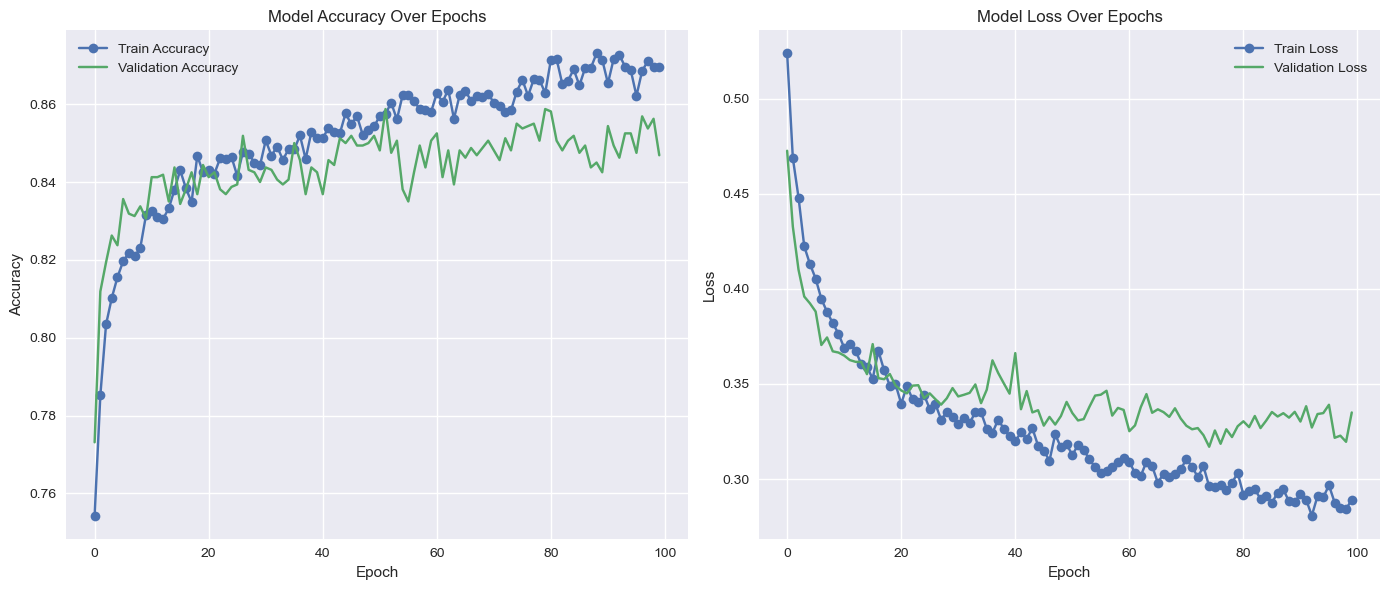

In [ ]:
import matplotlib.pyplot as plt

# Training history curves
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy', marker='x')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history.get('val_loss', []), label='Validation Loss', marker='x')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


* Confusion matrices

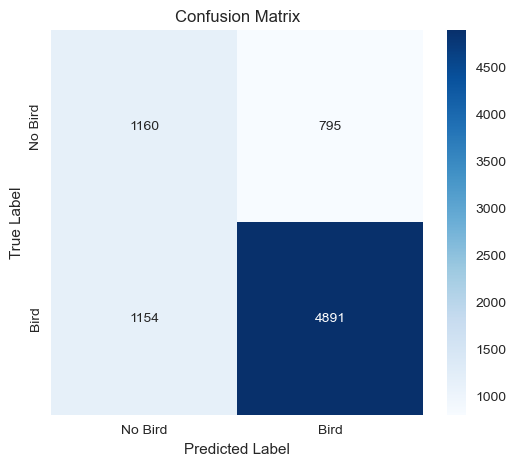

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute the matrix again to be safe
cm = confusion_matrix(y_noisy, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Bird', 'Bird'], yticklabels=['No Bird', 'Bird'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Denoising

In [ ]:
#denoising

In [ ]:
pip install librosa noisereduce soundfile tqdm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import soundfile as sf
import noisereduce as nr
from pathlib import Path
from joblib import Parallel, delayed
import librosa
import numpy as np
from tqdm import tqdm

# === CONFIGURATION ===
INPUT_DIR = Path("/Users/beneditoferrao/Desktop/STMAE project/wav")
OUTPUT_DIR = Path("/Users/beneditoferrao/Desktop/STMAE project/wav_denoised")
SAMPLE_RATE = 22050  # Resample target

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# List of all WAV files
wav_files = list(INPUT_DIR.glob("*.wav"))
print(f"🔍 Found {len(wav_files)} WAV files to process.")

# === DENOISE FUNCTION ===
def process_file(file_path):
    try:
        # Load with soundfile
        y, sr = sf.read(file_path)
        if y.ndim > 1:
            y = np.mean(y, axis=1)  # Convert stereo to mono

        # Resample if needed
        if sr != SAMPLE_RATE:
            y = librosa.resample(y, orig_sr=sr, target_sr=SAMPLE_RATE)
            sr = SAMPLE_RATE

        # Denoise
        y_denoised = nr.reduce_noise(y=y, sr=sr)

        # Save output
        out_path = OUTPUT_DIR / file_path.name
        sf.write(out_path, y_denoised, sr)
        return f"✅ {file_path.name}"
    except Exception as e:
        return f"❌ {file_path.name} failed: {e}"

# === RUN IN PARALLEL ===
results = Parallel(n_jobs=-1)(
    delayed(process_file)(fp) for fp in tqdm(wav_files, desc="🚀 Denoising in parallel")
)

# Print summary of results
for r in results:
    print(r)

🔍 Found 8000 WAV files to process.


🚀 Denoising in parallel:   0%|                | 8/8000 [00:00<02:25, 55.11it/s]

KeyboardInterrupt: 

In [ ]:
model_hyb.save("/Users/beneditoferrao/Desktop/STMAE project/model_hyb.h5")

🚀 Denoising in parallel:   0%|                | 8/8000 [00:14<02:25, 55.11it/s]

In [ ]:
#test on desnoised dataset

In [ ]:
model_hyb.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 216, 56, 16)    │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 216, 28, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 216, 28, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 216, 26, 16)    │           784 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 216, 13, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 216, 13, 16)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 216, 11, 32)    │         1,568 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 216, 6, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 216, 6, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 216, 192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 216, 16)        │        13,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,907 (62.14 KB)

 Trainable params: 15,905 (62.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

# === CONFIGURATION ===
WAV_DIR = Path("/Users/beneditoferrao/Desktop/STMAE project/wav_denoised")
CSV_PATH = "/Users/beneditoferrao/Desktop/STMAE project/warblrb10k_public_metadata_2018.csv"
SAMPLE_RATE = 22050
DURATION = 10.0
TARGET_SAMPLES = int(SAMPLE_RATE * DURATION)
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64
TIME_FRAMES = 216

# === LOAD METADATA ===
meta_df = pd.read_csv(CSV_PATH)
meta_df['file_path'] = meta_df['itemid'].apply(lambda x: WAV_DIR / f"{x}.wav")
meta_df = meta_df[meta_df['file_path'].map(Path.exists)]

# === LOAD AUDIO & COMPUTE MEL SPECTROGRAM ===
X = []
y = []

for _, row in meta_df.iterrows():
    path = row['file_path']
    label = row['hasbird']
    y.append(label)

    signal, _ = librosa.load(path, sr=SAMPLE_RATE)
    if len(signal) > TARGET_SAMPLES:
        signal = signal[:TARGET_SAMPLES]
    else:
        signal = np.pad(signal, (0, TARGET_SAMPLES - len(signal)), mode='constant')

    # ✅ Compute Mel-spectrogram
    S = librosa.feature.melspectrogram(
        y=signal,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Crop or pad to (64, 216)
    if S_dB.shape[1] < TIME_FRAMES:
        S_dB = np.pad(S_dB, ((0, 0), (0, TIME_FRAMES - S_dB.shape[1])), mode='constant')
    else:
        S_dB = S_dB[:, :TIME_FRAMES]

    # Transpose and expand dims: (216, 64, 1)
    S_input = np.transpose(S_dB, (1, 0))
    S_input = np.expand_dims(S_input, -1)
    X.append(S_input)

# === FINAL INPUT SHAPE ===
X = np.array(X)  # → (N, 216, 64, 1)
y = np.array(y)
print("✅ Final input shape:", X.shape)
print("✅ Label shape:", y.shape)

# === LOAD MODEL ===
model_path = "/Users/beneditoferrao/Desktop/STMAE project/model_hyb.h5"
model_hyb = tf.keras.models.load_model(model_path)
print("📐 Model expects input shape:", model_hyb.input_shape)

# === EVALUATE ===
loss, acc = model_hyb.evaluate(X, y, verbose=1)
print(f"\n📊 Accuracy: {acc:.4f}")
print(f"🧪 Loss: {loss:.4f}")

# === PREDICT & METRICS ===
y_pred_proba = model_hyb.predict(X)
y_pred = (y_pred_proba > 0.5).astype(int)

auc = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred)

print(f"📈 AUC Score: {auc:.4f}")
print("🧩 Confusion Matrix:\n", cm)
print("\n📋 Classification Report:")
print(classification_report(y, y_pred))


✅ Final input shape: (8000, 216, 64, 1)
✅ Label shape: (8000,)
📐 Model expects input shape: (None, 216, 64, 1)
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7521 - loss: 0.5424

📊 Accuracy: 0.7479
🧪 Loss: 0.5512
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step
📈 AUC Score: 0.5991
🧩 Confusion Matrix:
 [[  64 1891]
 [ 126 5919]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.03      0.06      1955
           1       0.76      0.98      0.85      6045

    accuracy                           0.75      8000
   macro avg       0.55      0.51      0.46      8000
weighted avg       0.65      0.75      0.66      8000



In [ ]:
#plot for denoised accuracy

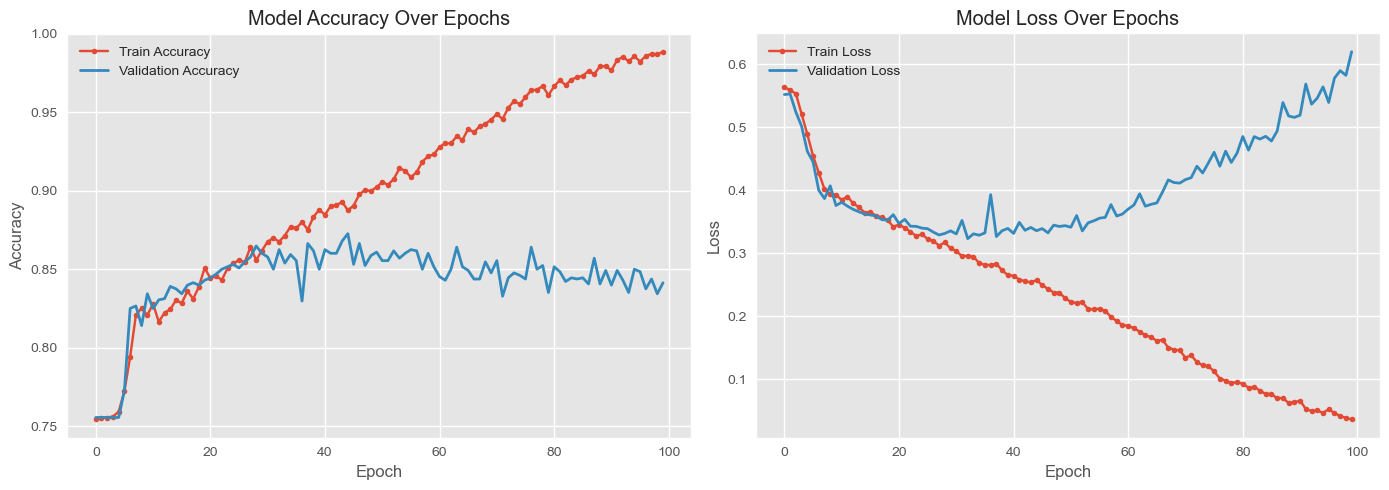

In [ ]:
import matplotlib.pyplot as plt

# Optional: use a clean built-in style
plt.style.use("ggplot")  # Or comment this line out if you want default

# === PLOT TRAINING AND VALIDATION CURVES ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o', markersize=4)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title("Model Accuracy Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.grid(True)
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o', markersize=4)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title("Model Loss Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
#training, validating and testing with denoised data

In [ ]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import os

# === CONFIGURATION ===
WAV_DIR = Path("/Users/beneditoferrao/Desktop/STMAE project/wav_denoised")
CSV_PATH = "/Users/beneditoferrao/Desktop/STMAE project/warblrb10k_public_metadata_2018.csv"
MODEL_SAVE_PATH = "/Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5"
SAMPLE_RATE = 22050
DURATION = 10.0
TARGET_SAMPLES = int(SAMPLE_RATE * DURATION)
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64
TIME_FRAMES = 216
BATCH_SIZE = 32
EPOCHS = 100

# === LOAD METADATA ===
meta_df = pd.read_csv(CSV_PATH)
meta_df['file_path'] = meta_df['itemid'].apply(lambda x: WAV_DIR / f"{x}.wav")
meta_df = meta_df[meta_df['file_path'].map(Path.exists)]

# === LOAD AUDIO & MEL-SPECTROGRAMS ===
X = []
y = []

for _, row in meta_df.iterrows():
    path = row['file_path']
    label = row['hasbird']
    y.append(label)

    signal, _ = librosa.load(path, sr=SAMPLE_RATE)
    if len(signal) > TARGET_SAMPLES:
        signal = signal[:TARGET_SAMPLES]
    else:
        signal = np.pad(signal, (0, TARGET_SAMPLES - len(signal)), mode='constant')

    S = librosa.feature.melspectrogram(
        y=signal,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    S_dB = librosa.power_to_db(S, ref=np.max)

    if S_dB.shape[1] < TIME_FRAMES:
        S_dB = np.pad(S_dB, ((0, 0), (0, TIME_FRAMES - S_dB.shape[1])), mode='constant')
    else:
        S_dB = S_dB[:, :TIME_FRAMES]

    S_input = np.transpose(S_dB, (1, 0))  # (216, 64)
    S_input = np.expand_dims(S_input, -1)  # (216, 64, 1)
    X.append(S_input)

X = np.array(X)
y = np.array(y)
print("✅ Final data shape:", X.shape, y.shape)

# === SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# === MODEL ARCHITECTURE ===
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(216, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Reshape((54, -1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# === CALLBACKS ===
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# === TRAIN MODEL ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)



✅ Final data shape: (8000, 216, 64, 1) (8000,)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 216, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 108, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 108, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 54, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,825 (1.15 MB)

 Trainable params: 301,825 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7430 - loss: 0.5770
Epoch 1: val_accuracy improved from -inf to 0.75547, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.7430 - loss: 0.5769 - val_accuracy: 0.7555 - val_loss: 0.5521
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7562 - loss: 0.5610
Epoch 2: val_accuracy did not improve from 0.75547
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.7562 - loss: 0.5610 - val_accuracy: 0.7555 - val_loss: 0.5529
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7566 - loss: 0.5627
Epoch 3: val_accuracy did not improve from 0.75547
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.7566 - loss: 0.5626 - val_accuracy: 0.7555 - val_loss: 0.5244
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7628 - loss: 0.5198
Epoch 4: val_accuracy did not improve from 0.75547
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7627 - loss: 0.5198 - val_accuracy: 0.7555 - val_loss: 0.5017
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7620 - loss: 0.4894
Epoch 5: va

160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.7694 - loss: 0.4606 - val_accuracy: 0.7727 - val_loss: 0.4451
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7812 - loss: 0.4453
Epoch 7: val_accuracy improved from 0.77266 to 0.82500, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.7813 - loss: 0.4451 - val_accuracy: 0.8250 - val_loss: 0.4000
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8200 - loss: 0.3981
Epoch 8: val_accuracy improved from 0.82500 to 0.82656, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8200 - loss: 0.3982 - val_accuracy: 0.8266 - val_loss: 0.3868
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8329 - loss: 0.3877
Epoch 9: val_accuracy did not improve from 0.82656
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8328 - loss: 0.3877 - val_accuracy: 0.8141 - val_loss: 0.4071
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8180 - loss: 0.3933
Epoch 10: val_accuracy improved from 0.82656 to 0.83438, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8180 - loss: 0.3933 - val_accuracy: 0.8344 - val_loss: 0.3758
Epoch 11/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8294 - loss: 0.3916
Epoch 11: val_accuracy did not improve from 0.83438
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8294 - loss: 0.3915 - val_accuracy: 0.8250 - val_loss: 0.3810
Epoch 12/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8144 - loss: 0.3989
Epoch 12: val_accuracy did not improve from 0.83438
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8144 - loss: 0.3989 - val_accuracy: 0.8305 - val_loss: 0.3748
Epoch 13/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8233 - loss: 0.3799
Epoch 13: val_accuracy did not improve from 0.83438
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8233 - loss: 0.3799 - val_accuracy: 0.8313 - val_loss: 0.3697
Epoch 14/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8234 - loss: 0.3691
Epoc

160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8234 - loss: 0.3691 - val_accuracy: 0.8391 - val_loss: 0.3658
Epoch 15/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8264 - loss: 0.3653
Epoch 15: val_accuracy did not improve from 0.83906
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.8264 - loss: 0.3653 - val_accuracy: 0.8375 - val_loss: 0.3624
Epoch 16/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8367 - loss: 0.3614
Epoch 16: val_accuracy did not improve from 0.83906
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8367 - loss: 0.3614 - val_accuracy: 0.8344 - val_loss: 0.3608
Epoch 17/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8371 - loss: 0.3593
Epoch 17: val_accuracy improved from 0.83906 to 0.83984, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.8371 - loss: 0.3593 - val_accuracy: 0.8398 - val_loss: 0.3593
Epoch 18/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8312 - loss: 0.3582
Epoch 18: val_accuracy improved from 0.83984 to 0.84141, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8312 - loss: 0.3582 - val_accuracy: 0.8414 - val_loss: 0.3535
Epoch 19/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8452 - loss: 0.3452
Epoch 19: val_accuracy did not improve from 0.84141
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.8452 - loss: 0.3453 - val_accuracy: 0.8398 - val_loss: 0.3523
Epoch 20/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8408 - loss: 0.3533
Epoch 20: val_accuracy improved from 0.84141 to 0.84297, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8408 - loss: 0.3532 - val_accuracy: 0.8430 - val_loss: 0.3612
Epoch 21/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8490 - loss: 0.3345
Epoch 21: val_accuracy improved from 0.84297 to 0.84453, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8490 - loss: 0.3345 - val_accuracy: 0.8445 - val_loss: 0.3473
Epoch 22/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8428 - loss: 0.3431
Epoch 22: val_accuracy improved from 0.84453 to 0.84688, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8428 - loss: 0.3431 - val_accuracy: 0.8469 - val_loss: 0.3538
Epoch 23/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8452 - loss: 0.3300
Epoch 23: val_accuracy improved from 0.84688 to 0.85000, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.8452 - loss: 0.3301 - val_accuracy: 0.8500 - val_loss: 0.3430
Epoch 24/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8535 - loss: 0.3208
Epoch 24: val_accuracy improved from 0.85000 to 0.85156, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8535 - loss: 0.3208 - val_accuracy: 0.8516 - val_loss: 0.3426
Epoch 25/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8522 - loss: 0.3277
Epoch 25: val_accuracy improved from 0.85156 to 0.85312, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8522 - loss: 0.3277 - val_accuracy: 0.8531 - val_loss: 0.3399
Epoch 26/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8494 - loss: 0.3274
Epoch 26: val_accuracy did not improve from 0.85312
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8495 - loss: 0.3274 - val_accuracy: 0.8508 - val_loss: 0.3389
Epoch 27/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8589 - loss: 0.3107
Epoch 27: val_accuracy improved from 0.85312 to 0.85469, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.8589 - loss: 0.3107 - val_accuracy: 0.8547 - val_loss: 0.3335
Epoch 28/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8746 - loss: 0.3024
Epoch 28: val_accuracy improved from 0.85469 to 0.85781, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8745 - loss: 0.3025 - val_accuracy: 0.8578 - val_loss: 0.3290
Epoch 29/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8579 - loss: 0.3170
Epoch 29: val_accuracy improved from 0.85781 to 0.86484, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8579 - loss: 0.3170 - val_accuracy: 0.8648 - val_loss: 0.3314
Epoch 30/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8684 - loss: 0.2961
Epoch 30: val_accuracy did not improve from 0.86484
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8683 - loss: 0.2961 - val_accuracy: 0.8602 - val_loss: 0.3356
Epoch 31/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8607 - loss: 0.3169
Epoch 31: val_accuracy did not improve from 0.86484
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8607 - loss: 0.3169 - val_accuracy: 0.8578 - val_loss: 0.3307
Epoch 32/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8607 - loss: 0.3074
Epoch 32: val_accuracy did not improve from 0.86484
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.8608 - loss: 0.3073 - val_accuracy: 0.8500 - val_loss: 0.3522
Epoch 33/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8651 - loss: 0.2952
Epoc

160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8642 - loss: 0.3038 - val_accuracy: 0.8664 - val_loss: 0.3265
Epoch 39/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8890 - loss: 0.2624
Epoch 39: val_accuracy did not improve from 0.86641
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8890 - loss: 0.2625 - val_accuracy: 0.8617 - val_loss: 0.3358
Epoch 40/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8900 - loss: 0.2623
Epoch 40: val_accuracy did not improve from 0.86641
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.8900 - loss: 0.2623 - val_accuracy: 0.8500 - val_loss: 0.3394
Epoch 41/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8900 - loss: 0.2617
Epoch 41: val_accuracy did not improve from 0.86641
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8900 - loss: 0.2617 - val_accuracy: 0.8625 - val_loss: 0.3315
Epoch 42/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8945 - loss: 0.2517
Epoc

160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8935 - loss: 0.2530 - val_accuracy: 0.8680 - val_loss: 0.3410
Epoch 45/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8872 - loss: 0.2591
Epoch 45: val_accuracy improved from 0.86797 to 0.87266, saving model to /Users/beneditoferrao/Desktop/STMAE project/model_denoised_mel_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8872 - loss: 0.2591 - val_accuracy: 0.8727 - val_loss: 0.3358
Epoch 46/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8894 - loss: 0.2522
Epoch 46: val_accuracy did not improve from 0.87266
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8894 - loss: 0.2522 - val_accuracy: 0.8531 - val_loss: 0.3391
Epoch 47/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8927 - loss: 0.2549
Epoch 47: val_accuracy did not improve from 0.87266
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8927 - loss: 0.2548 - val_accuracy: 0.8664 - val_loss: 0.3324
Epoch 48/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9104 - loss: 0.2299
Epoch 48: val_accuracy did not improve from 0.87266
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9104 - loss: 0.2300 - val_accuracy: 0.8523 - val_loss: 0.3446
Epoch 49/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8973 - loss: 0.2388
Epoc


✅ Best model loaded from checkpoint.
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

🎯 BEST TEST ACCURACY: 0.8438
🧪 FINAL TEST LOSS: 0.3384
📈 AUC Score: 0.9014

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.58      0.64       391
           1       0.87      0.93      0.90      1209

    accuracy                           0.84      1600
   macro avg       0.80      0.75      0.77      1600
weighted avg       0.84      0.84      0.84      1600



/var/folders/j2/79dg6w1d3zs5msr73rl83jd00000gn/T/ipykernel_23944/939995699.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j2/79dg6w1d3zs5msr73rl83jd00000gn/T/ipykernel_23944/939995699.py:42: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


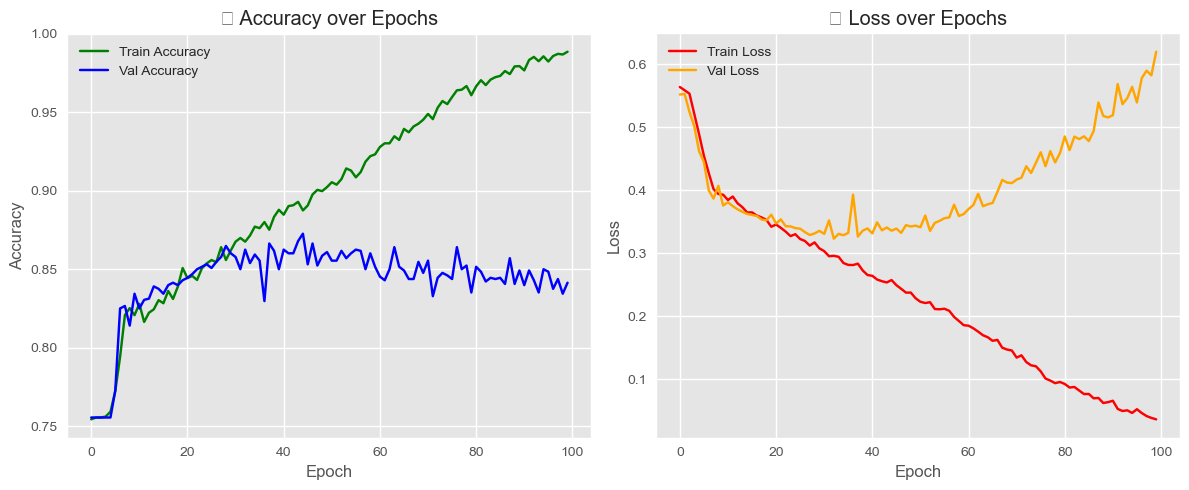

In [ ]:
# === LOAD BEST MODEL ===
best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
print("\n✅ Best model loaded from checkpoint.")

# === EVALUATE ON TEST SET ===
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# === METRICS ===
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n🎯 BEST TEST ACCURACY: {test_acc:.4f}")
print(f"🧪 FINAL TEST LOSS: {test_loss:.4f}")
print(f"📈 AUC Score: {auc:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# === PLOT TRAINING AND VALIDATION CURVES ===
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='blue')
plt.title("📊 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title("📉 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()